<a href="https://colab.research.google.com/github/samitha278/multilayer-perceptron-char-lm/blob/main/mlp_backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import random
import gdown
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#https://drive.google.com/file/d/1aLPTEpFPciZPYvBORlfOBSOohkwYyrqV/view?usp=drive_link

file_id = "1aLPTEpFPciZPYvBORlfOBSOohkwYyrqV"
url = f"https://drive.google.com/uc?id={file_id}"

output = "names.txt"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1aLPTEpFPciZPYvBORlfOBSOohkwYyrqV
To: /content/names.txt
100%|██████████| 228k/228k [00:00<00:00, 81.1MB/s]


'names.txt'

In [3]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
#character mapping
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


### Build the dataset

In [5]:
block_size = 3 # context length

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


random.seed(278)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182418, 3]) torch.Size([182418])
torch.Size([22885, 3]) torch.Size([22885])
torch.Size([22843, 3]) torch.Size([22843])


### Build MLP

In [6]:
n_embd = 10      # dimensionality of the character embedding vectors
n_hidden = 64    # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)


# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 useless because of BN


# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1


# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1



parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

4137


### Comparing manual gradients to PyTorch gradients

In [7]:
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

## Forward pass

In [8]:
batch_size = 32
n = batch_size
#minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [9]:

emb = C[Xb]                         # characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors


# Linear layer 1
hprebn = embcat @ W1 + b1           # hidden layer pre-activation


# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani

bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # Bessel's correction

bnvar_inv = (bnvar + 1e-5)**-0.5

bnraw = bndiff * bnvar_inv



hpreact = bngain * bnraw + bnbias





# # hidden layer - Non-linearity
h = torch.tanh(hpreact)


# Linear layer 2
logits = h @ W2 + b2 # output layer

# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability

counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1

probs = counts * counts_sum_inv
logprobs = probs.log()

loss = -logprobs[range(n), Yb].mean()




# PyTorch backward pass
for p in parameters:
  p.grad = None

for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.4735, grad_fn=<NegBackward0>)

## Backprop - manually



In [20]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n),Yb] = -1.0/n
dprobs = dlogprobs * (1.0/probs)
dcounts = dprobs * counts_sum_inv
dcounts_sum_inv = (dprobs * counts).sum(1,keepdims = True)
dcounts_sum = dcounts_sum_inv * (-counts_sum**-2)
dcounts += dcounts_sum * torch.ones_like(counts)
dnorm_logits = counts*dcounts  #norm_logits.exp()
dlogits = dnorm_logits
dlogit_maxes = (-dnorm_logits).sum(1,keepdims = True)
dlogits += F.one_hot(logits.max(1).indices,num_classes=logits.shape[1]) * dlogit_maxes

dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)


dhpreact = (1.0 - h**2) * dh


dbngain = (dhpreact * bnraw).sum(0,keepdim = True)
dbnraw = dhpreact * bngain
dbnbias = dhpreact.sum(0,keepdim = True)


dbndiff = dbnraw * bnvar_inv
dbnvar_inv = (dbnraw * bndiff).sum(0,keepdim = True)
dbnvar = dbnvar_inv * (-0.5*(bnvar + 1e-5)**-1.5)
dbndiff2 = dbnvar * (1/(n-1))*torch.ones_like(bndiff2)
dbndiff += dbndiff2 * 2* bndiff
dhprebn = dbndiff
dbnmeani = -dbndiff.sum(0)
dhprebn += dbnmeani * 1/n * torch.ones_like(hprebn)


dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)

demb = dembcat.view(emb.shape)

dC = torch.zeros_like(C)
for i in range(demb.shape[0]):
  for j in  range(demb.shape[1]):

    ix = Xb[i,j]

    dC[ix] += demb[i,j]
















cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)



logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: False | approximate: True  | maxdiff: 7.916241884231567e-09
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
bngain          | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09
bnbias          | exact: False | approximate: True  | maxdiff: 3.725290298

### dL/dlogits

In [24]:
dlogits = F.softmax(logits)
dlogits[range(n),Yb] -= 1
dlogits /= n
cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 7.2177499532699585e-09


/tmp/ipython-input-1349672655.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  dlogits = F.softmax(logits)


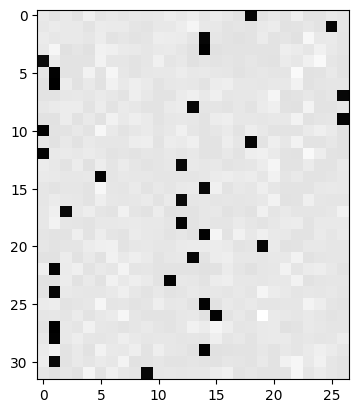

In [28]:
plt.imshow(dlogits.detach(),cmap = "gray")